In [1]:
import os
import re
from scipy import stats
import tempfile
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import rgb2hex
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
import sys
import seaborn as sns
sys.path.append('../../CEBRA_analysis/')
from dataset_load import data_load
from scipy.stats import mannwhitneyu, normaltest, ttest_ind, levene, ttest_rel, shapiro

from sklearn.inspection import permutation_importance

In [2]:
def split_quantify_lda(x, y, animals_id, run_id, idxs):
    groups = [a+i for a, i in zip(animals_id, run_id)]
    
    rng = np.random.default_rng(seed=42)  # for reproducibility
    unique_groups = np.unique(groups)      # array of shape (55,)
    rng.shuffle(unique_groups)   
    
    
    gkf = GroupKFold(n_splits=11)
    gkf.get_n_splits(groups=groups)
    
    X_unique = np.arange(len(unique_groups))
    
    perms = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_unique, groups=unique_groups)):
    
        train_groups = unique_groups[train_idx]
        test_groups  = unique_groups[test_idx]
        
        train_mask = np.isin(groups, train_groups)
        test_mask  = np.isin(groups, test_groups)
        
        X_train, y_train = x.iloc[train_mask, idxs], y[train_mask]
        X_test,  y_test  = x.iloc[test_mask, idxs],  y[test_mask]
    
        clf = LinearDiscriminantAnalysis(store_covariance=True, n_components=2)
        clf.fit(X_train, y_train)
        perm = permutation_importance(clf, X_test, y_test, n_repeats=3, random_state=0, scoring="balanced_accuracy")
        perms.append(perm)
    return perms

In [3]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

In [4]:
data_dict = data_load(input_folder, variables_to_drop, skipdates)
x = data_dict["X_pd"]
y = data_dict["y_pd"]
animals_id = data_dict["animals_id_pd"]
run_id = data_dict["run_id_pd"]

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [5]:
s_kin = slice(None, 36)
perms_kin = split_quantify_lda(x, y, animals_id, run_id, idxs=s_kin)

perms_importance_kin = pd.DataFrame(index=range(0,12), columns=x.iloc[:, s_kin].columns)

for j, r in enumerate(perms_kin):
    for i in r.importances_mean.argsort()[::-1]:
        #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        perms_importance_kin.loc[j, x.iloc[:, s_kin].columns[i]] = r.importances_mean[i]

In [6]:
perms_importance_kin

,left_crest_angle_mean,left_hip_angle_mean,left_knee_angle_mean,left_ankle_angle_mean,right_crest_angle_mean,right_hip_angle_mean,right_knee_angle_mean,right_ankle_angle_mean,trunk_cross_l_angle_mean,trunk_cross_r_angle_mean,...,rmtp_speed_mean,rankle_speed_mean,rknee_speed_mean,rhip_speed_mean,rcrest_speed_mean,rshoulder_speed_mean,lmtp_height,lmtp_fwd_move,rmtp_height,rmtp_fwd_move
0,0.019838,-0.011026,0.016483,0.000783,-0.000138,0.017825,-0.003817,-0.008698,0.026264,-0.000022,...,0.008219,0.001223,0.015621,0.016656,0.014364,0.023211,0.001308,0.001262,0.002556,0.00195
1,-0.001877,-0.01627,0.012959,-0.007287,-0.001557,0.06059,-0.060676,-0.038276,0.016306,0.005481,...,0.003427,0.00221,0.010712,0.005967,0.007343,0.019609,0.000446,0.000759,0.000743,0.001613
2,-0.002208,0.013322,-0.005561,-0.003234,0.002932,-0.000181,0.14372,0.022387,0.040155,-0.001397,...,0.01467,0.002159,0.044909,0.041415,0.057961,0.075856,-0.000406,0.001906,-0.000376,0.00272
3,0.01766,0.010585,-0.021128,-0.033314,-0.004825,-0.039032,0.067626,0.011558,0.063004,-0.047292,...,-0.004454,-0.004487,-0.010798,0.013133,0.015297,0.000979,-0.002415,0.000678,0.000568,0.00133
4,0.017588,0.019603,0.012369,0.007503,-0.001465,0.021898,0.013838,0.00462,0.004451,0.005378,...,0.007112,0.001882,0.021567,0.008927,0.014327,0.052638,0.000545,0.000391,-0.00012,-0.00025
5,-0.001486,0.016813,-0.013893,0.000427,0.007437,-0.006445,0.018372,0.005482,-0.019447,0.002688,...,-0.010695,0.000077,0.01225,0.01003,0.010525,0.012155,0.000435,0.00106,-0.000442,0.000867
6,-0.008923,0.011173,0.002113,-0.008379,0.012672,0.021159,0.008698,0.023131,-0.019594,-0.011757,...,0.01073,0.00404,0.029962,0.02483,0.024528,0.031277,-0.004271,0.00301,0.000918,0.001167
7,-0.019741,0.020123,0.001769,0.000538,-0.003132,0.003468,-0.038309,-0.042447,-0.026999,0.000087,...,-0.009365,0.002001,-0.015717,-0.012257,-0.01771,-0.014985,0.001185,0.001439,0.002153,0.002924
8,0.002701,-0.011555,-0.002321,-0.000429,-0.013719,0.035854,-0.000872,0.002969,-0.009977,-0.007779,...,0.008932,0.000397,0.005022,0.009349,0.007417,-0.002439,-0.000779,0.000285,-0.001366,0.000727
9,0.013244,0.007186,0.003166,0.011563,-0.00727,-0.01864,-0.004836,-0.000262,0.015256,-0.006748,...,0.003984,0.003736,0.014194,0.022694,0.024041,0.022247,0.001555,-0.00007,0.002509,0.002764


In [7]:
perms_importance_avg_kin = perms_importance_kin.mean(axis=0)

sort_idx_kin = np.argsort(perms_importance_avg_kin)[::-1]
sorted_cols_kin = perms_importance_kin.columns[sort_idx_kin]

perms_importance_kin = perms_importance_kin.loc[:, sorted_cols_kin]

In [8]:
feats_n = 5
cmap = plt.get_cmap('twilight')
feats_cmap = cmap(np.linspace(0.1, 1, 6))[:feats_n]
cmap_d = {k : v for k, v in zip(perms_importance_kin.iloc[:, :feats_n].columns, feats_cmap)}

In [9]:
perms_importance_avg_kin

left_crest_angle_mean                  0.002667
left_hip_angle_mean                    0.008188
left_knee_angle_mean                  -0.000571
left_ankle_angle_mean                 -0.002981
right_crest_angle_mean                 0.000124
right_hip_angle_mean                   0.011253
right_knee_angle_mean                  0.011244
right_ankle_angle_mean                -0.001815
trunk_cross_l_angle_mean               0.007425
trunk_cross_r_angle_mean               -0.00461
left_crest_angular_velocity_mean       0.000155
left_hip_angular_velocity_mean         0.000326
left_knee_angular_velocity_mean        0.001486
left_ankle_angular_velocity_mean       0.000079
right_crest_angular_velocity_mean     -0.000007
right_hip_angular_velocity_mean        0.000181
right_knee_angular_velocity_mean       0.000837
right_ankle_angular_velocity_mean      0.000037
trunk_cross_l_angular_velocity_mean     0.00004
trunk_cross_r_angular_velocity_mean    0.000265
lmtp_speed_mean                       -0

[-0.04  0.    0.04  0.08]


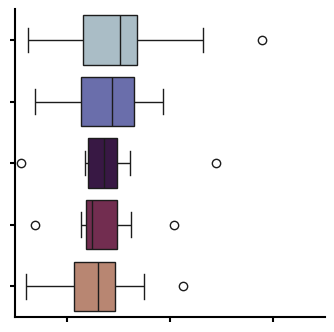

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
cmap = plt.get_cmap('twilight')
cmap = cmap(np.linspace(0.1, 1, 6))
sns.boxplot(perms_importance_kin.iloc[:, :feats_n], orient="h", ax=ax, palette=cmap_d)
print(ax.get_xticks()[::2])
ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
ax.set_yticks(ticks=ax.get_yticks(), labels=[], fontsize=15)

ax.set_xlim(-0.02, 0.10)

ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_boxplot_kin.png", transparent=True)
plt.savefig("lda_boxplot_kin.svg", transparent=True)

In [11]:
s_kin = slice(None, 36)
x_fit=x.iloc[:, s_kin]
clf_kin = LinearDiscriminantAnalysis(store_covariance=True, n_components=2)
clf_kin.fit(x_fit, y)
prediction_kin = clf_kin.predict(x_fit)

df_scalings_kin = pd.DataFrame(clf_kin.scalings_, columns=["x", "y"])
df_scalings_kin["magn"] = np.sqrt(df_scalings_kin["x"]**2 + df_scalings_kin["y"]**2)
df_scalings_kin["feats"] = x_fit.columns

x [-4.  0.  4.  8.]
y [-8. -4.  0.  4.]


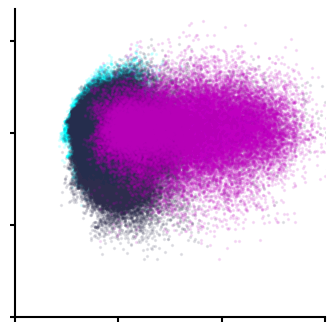

In [16]:
x_trans = clf_kin.transform(x_fit)
fig, ax = plt.subplots(figsize=(4,4))

cmap = plt.get_cmap('twilight')
cmap = cmap(np.linspace(0.1, 1, 6))

colors = ["black", "lightgray", "slategray"]
colors = ["cyan", "#2e2d4d", "m"]
for color, i, target_name in zip(colors, [0, 1, 2], y):
    sc=ax.scatter(
        x_trans[y == i, 0], x_trans[y == i, 1], alpha=0.1, color=color, label=i, s=2
    )

feats = perms_importance_kin.iloc[:, :feats_n].columns
magns = df_scalings_kin[df_scalings_kin["feats"].isin(feats)][["x", "y", "feats"]].values

#for i, val in enumerate(magns):
#    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=val[2], alpha=1, color=cmap_d[val[2]], head_width=0.3, head_length=0.3)

#sc.set_rasterized(True)
#plt.legend(loc=[1,0])
#ax.set_ylim(-10, 10)
ax.set_xlim(-2.5, 8)
print("x", ax.get_xticks()[::2])
print( "y", ax.get_yticks()[::2])
ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[] )
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[] )


#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_kinematic_scatter_only.png", transparent=True)
plt.savefig("lda_kinematic_scatter_only.svg", transparent=True)

In [25]:
data = pd.DataFrame(x_trans, columns=["PC1", "PC2"])
data["label"] = y
colors = ["cyan", "#2e2d4d", "m"]
vals = [0, 1, 2]  # Discretizes the interpolation into bins
cmap_neurokin_d = {k: v for k, v in zip(vals, colors)}¢
f = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))


x [-2  2  6]
y [-6. -2.  2.  6.]


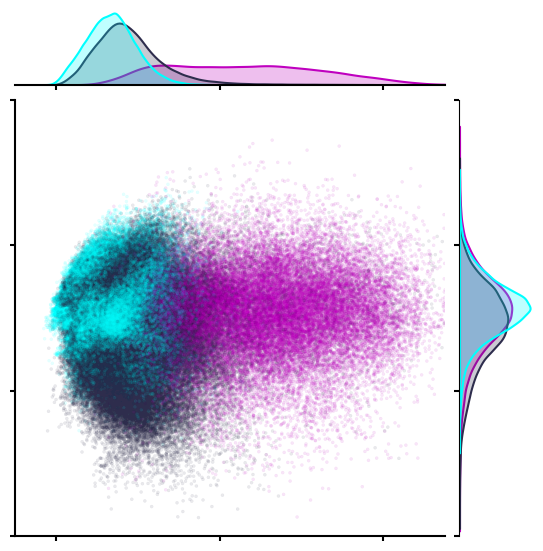

In [41]:
jp = sns.jointplot(data=data, x="PC1", y="PC2", hue="label", palette=cmap_neurokin_d, s=5, edgecolor=None, alpha=0.1, xlim=(-2.5,5), marginal_kws={'linewidth': 1.5, "common_norm": False})

jp.ax_marg_x.spines[['bottom']].set_linewidth(1.5)
jp.ax_marg_y.spines[['bottom']].set_linewidth(1.5)
jp.ax_marg_x.tick_params(width=1.5)
jp.ax_marg_y.tick_params(width=1.5)

ax = jp.ax_joint

for i, val in enumerate(magns):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=val[2], alpha=0, color=cmap_d[val[2]], head_width=0.3, head_length=0.3)

plt.legend([],[], frameon=False)
ax.set_xlim(-3, 7.5)
ax.set_ylim(-6, 6)


ax.set_xticks(ticks=[-2, 2, 6], labels=[] )
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[] )
print("x", ax.get_xticks())
print( "y", ax.get_yticks())
#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_kinematics_scatter_density.png", transparent=True, dpi=300)

## Correlation analysis

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

s = slice(None, 36)
X = x.iloc[:, s]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [ ]:
s = slice(36, None)
X = x.iloc[:, s]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
ùdendro = hierarchy.dendrogram(dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()